### Load libraries

In [2]:
# Library for data visualisation
import pandas as pd
import numpy as np
from pathlib import Path
import pathlib
import os
from PIL import Image
import numpy as np
import json
import torch
from torchvision.ops import box_convert
from typing import List, Dict
from skimage.io import imread
import pickle

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
import torch

import torchvision.transforms as T

In [9]:
import tqdm
def data_fix(img_list,ann_list):

    root_dir = pathlib.Path('../literature/Other/supervisely')
    img_dir = pathlib.Path(root_dir, 'wrist/img')

    for idx in tqdm.tqdm(range(10)):#tqdm.tqdm(range(len(img_list))):
        img_path = os.path.join(img_list[idx])
        ann_path = os.path.join(ann_list[idx])
        
        target = []
        d = {}

        box = []
        boxes = []
        labels = []
        area = []

        classes = {'fracture' : 1, 'text' : 2}

        

        with open(ann_path) as json_file:

            #Load the img
            name = pathlib.PurePath(ann_path).name.split('.')[0]
            image = img_dir / (str(name) + '.png')
            img = Image.open(img_path)

            obj_ids = np.unique(img)
            num_objs = len(obj_ids)
            
            #Load the JSON file
            data = json.load(json_file)


        for object_dict in data['objects']:
    
            # Check if object contains any fractures

            if object_dict['classTitle'] == "text" or object_dict['classTitle'] == "fracture":

                # Get points and convert them to int for display purposes
                top_left_point, bottom_right_point = object_dict['points']['exterior']
                top_left_point = list(map(int,top_left_point))
                bottom_right_point = list(map(int, bottom_right_point))
                box = (top_left_point+bottom_right_point)
                area.append((box[3] - box[1]) * (box[2] - box[0]))
                label = classes[object_dict['classTitle']]
                labels.append(label)
                boxes.append(box)
                

        boxes = torch.FloatTensor(boxes)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
                
        
        d["boxes"] = boxes
        d["labels"] = labels
        d["image_id"] = image_id
        d["area"] = area
        d["iscrowd"] = iscrowd

        target.append(d)

        

        ready_data = {'image_path' : img_path,'target' : target}

        path = os.path.join(root_dir,'wrist','train_pickle', name + '.pickle')

        with open(path, 'wb') as handle:
            pickle.dump(ready_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
#Set path to root dir (wrist folder)
root_dir = pathlib.Path('../literature/Other/supervisely')

# Path to annotation dir
ann_dir = pathlib.Path(root_dir, 'wrist/ann')

# Path to image dir
img_dir = pathlib.Path(root_dir, 'wrist/img')

# Lists
list_files = lambda start_dir: [str(item) for item in start_dir.iterdir()]
ann_list = list_files(ann_dir)
img_list = list_files(img_dir)
print('Number of annotations: {}'.format(len(ann_list)))

Number of annotations: 20327


### Takes time...



In [6]:
data_fix(img_list,ann_list)

100%|██████████| 10/10 [00:00<00:00, 24.85it/s]


In [7]:
instances = list(sorted(os.listdir(os.path.join('../literature/Other/supervisely/wrist', "train_pickle"))))
instances

['0001_1297860395_01_WRI-L1_M014.pickle',
 '0001_1297860435_01_WRI-L2_M014.pickle',
 '0002_0354485735_01_WRI-R1_F012.pickle',
 '0002_0354485759_01_WRI-R2_F012.pickle',
 '0003_0662359226_01_WRI-R1_M011.pickle',
 '0003_0662359351_01_WRI-R2_M011.pickle',
 '0003_0663715732_02_WRI-R1_M011.pickle',
 '0003_0663715782_02_WRI-R2_M011.pickle',
 '0003_0664918633_03_WRI-R1_M011.pickle',
 '0003_0664918693_03_WRI-R2_M011.pickle']

In [12]:
instance = os.path.join('../literature/Other/supervisely/wrist','train_pickle', instances[0])
instance

'../literature/Other/supervisely/wrist\\train_pickle\\0001_1297860395_01_WRI-L1_M014.pickle'

In [13]:
with open(instance, 'rb') as handle:
            data = pickle.load(handle)

In [14]:
data

{'image_path': '..\\literature\\Other\\supervisely\\wrist\\img\\0001_1297860395_01_WRI-L1_M014.png',
 'target': [{'boxes': tensor([[  1., 577.,  55., 641.]]),
   'labels': tensor([2]),
   'image_id': tensor([0]),
   'area': [3456],
   'iscrowd': tensor([0, 0, 0,  ..., 0, 0, 0])}]}

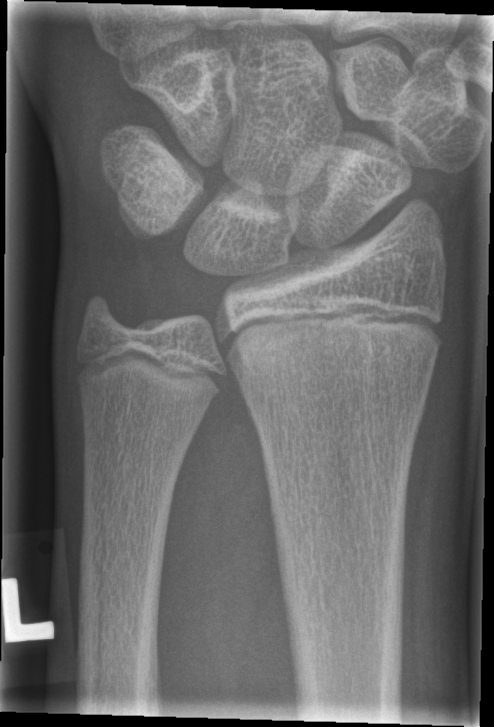

In [16]:
image = Image.open(data['image_path'])
image

In [18]:
image = transform(image)

In [17]:
class UnsqueezeTransform:
    def __call__(self, img):
        return torch.unsqueeze(img, 0)
    
transform = T.Compose([
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float),
    UnsqueezeTransform(),
])

In [1]:
import sys
import pathlib
from torch.utils.data import DataLoader
sys.path.append('../')
from src.data.my_dataset import XRayDataSet
from src.data.my_dataset import collate_fn



dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist'))
training_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4,collate_fn=collate_fn)
images , targets = next(iter(training_dataloader))

In [2]:
images

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),)

In [19]:
image

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [277]:
#dummy boxes and images format
images, boxes = torch.rand(2, 3, 600, 1200), torch.rand(2, 2, 4) 
labels = torch.randint(2, 91, (2, 2))
images = list(image for image in images)
targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)

In [278]:
images

[tensor([[[0.9276, 0.1281, 0.6903,  ..., 0.4694, 0.2134, 0.3491],
          [0.1106, 0.8379, 0.2917,  ..., 0.7601, 0.9315, 0.6346],
          [0.0673, 0.7664, 0.6359,  ..., 0.3762, 0.3918, 0.7940],
          ...,
          [0.4013, 0.5452, 0.5870,  ..., 0.7489, 0.5500, 0.1818],
          [0.0409, 0.3473, 0.9732,  ..., 0.6439, 0.5897, 0.0250],
          [0.5651, 0.7116, 0.4932,  ..., 0.0420, 0.0860, 0.4040]],
 
         [[0.3003, 0.4009, 0.7661,  ..., 0.9137, 0.0530, 0.9290],
          [0.6375, 0.2118, 0.9994,  ..., 0.6949, 0.0544, 0.1106],
          [0.2051, 0.3545, 0.8521,  ..., 0.8881, 0.6442, 0.0828],
          ...,
          [0.8141, 0.7944, 0.9162,  ..., 0.0027, 0.7186, 0.0873],
          [0.0442, 0.2439, 0.0738,  ..., 0.0582, 0.1005, 0.5050],
          [0.7917, 0.9321, 0.2083,  ..., 0.7094, 0.9648, 0.6935]],
 
         [[0.9421, 0.0498, 0.5414,  ..., 0.5097, 0.0289, 0.6503],
          [0.9065, 0.9180, 0.8132,  ..., 0.2254, 0.2308, 0.2106],
          [0.2305, 0.5883, 0.9827,  ...,

## Test rpg images that working 


In [3]:
instances = list(sorted(os.listdir(os.path.join('../literature/Other/supervisely/wrist', "train_pickles"))))
instances

['0001_1297860395_01_WRI-L1_M014.pickle',
 '0001_1297860435_01_WRI-L2_M014.pickle',
 '0002_0354485735_01_WRI-R1_F012.pickle',
 '0002_0354485759_01_WRI-R2_F012.pickle',
 '0003_0662359226_01_WRI-R1_M011.pickle',
 '0003_0662359351_01_WRI-R2_M011.pickle',
 '0003_0663715732_02_WRI-R1_M011.pickle',
 '0003_0663715782_02_WRI-R2_M011.pickle',
 '0003_0664918633_03_WRI-R1_M011.pickle',
 '0003_0664918693_03_WRI-R2_M011.pickle',
 '0004_0542630449_01_WRI-L1_M003.pickle',
 '0004_0542630513_01_WRI-L2_M003.pickle',
 '0005_0073601946_01_WRI-R1_F014.pickle',
 '0005_0073601967_01_WRI-R2_F014.pickle',
 '0006_0290481819_01_WRI-R2_M011.pickle',
 '0006_0290481856_01_WRI-R1_M011.pickle',
 '0007_0812696320_01_WRI-R1_M015.pickle',
 '0007_0812696396_01_WRI-R2_M015.pickle',
 '0008_1128992395_01_WRI-L1_M005.pickle',
 '0008_1128992441_01_WRI-L2_M005.pickle',
 '0009_1112587669_01_WRI-R1_F013.pickle',
 '0009_1112587738_01_WRI-R2_F013.pickle',
 '0010_0604034401_01_WRI-L1_M014.pickle',
 '0010_0604034442_01_WRI-L2_M014.p

In [6]:
instance = os.path.join('../literature/Other/supervisely/wrist','train_pickles', instances[0])
instance

'../literature/Other/supervisely/wrist\\train_pickles\\0001_1297860395_01_WRI-L1_M014.pickle'

In [7]:
with open(instance, 'rb') as handle:
    data = pickle.load(handle)

In [8]:
data

{'image': '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0001_1297860395_01_WRI-L1_M014.png',
 'target': {'boxes': tensor([[  1., 577.,  55., 641.]]),
  'labels': tensor([2]),
  'image_id': tensor([0]),
  'area': tensor([3456])}}

In [10]:
path = data['image']

In [12]:
from cv2 import cv2

img = cv2.imread(path)
cv2.imshow("test", img)
  
# waits for user to press any key
# (this is necessary to avoid Python kernel form crashing)
cv2.waitKey(0)
  
# closing all open windows
cv2.destroyAllWindows()

In [14]:
img.shape

(727, 494, 3)

In [15]:
img = T.ToTensor()(img).float()

In [16]:
img.shape

torch.Size([3, 727, 494])

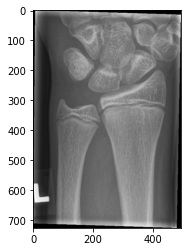

In [17]:
import matplotlib.pyplot as plt
#Convert the tensor to a numpy array
numpy_image = img.numpy()
# Transpose the dimensions to match the expected order of matplotlib
# (height, width, channels)
numpy_image = numpy_image.transpose(1, 2, 0)
# Display the image using matplotlib
plt.imshow(numpy_image)
plt.show()